# Simple CNN and residual models

In [1]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from IPython.core.display import display
import numpy as np
from scipy.signal import convolve
from torch.utils.data import Dataset, DataLoader


import torch
%matplotlib inline

In [2]:
# !conda install pytorch torchvision -c pytorch -y

## Load data

In [3]:
%%time
files = [f'/s3/mo-uki-radar-comp/20180915{h:02}{m:02}_nimrod_ng_radar_rainrate_composite_500m_UK' \
          for m in range(0,60,5) for h in range(6,12)]

cubes = iris.load(files)
cube = cubes[0]
cube = cube[:10*(cube.shape[0]//10), 1000:3000, 1000:2000]

/opt/conda/lib/python3.6/site-packages/iris/fileformats/nimrod_load_rules.py:246: TranslationWarning: Vertical coord 5 not yet handled
  "".format(v_type), TranslationWarning)


CPU times: user 4.75 s, sys: 2.92 s, total: 7.66 s
Wall time: 3min 31s


In [4]:
%%time
val = [f'/s3/mo-uki-radar-comp/20180916{h:02}{m:02}_nimrod_ng_radar_rainrate_composite_500m_UK' \
          for m in range(0,60,5) for h in range(6,8)]

val_cubes = iris.load(val)
val_cube = val_cubes[0]
val_cube = val_cube[:10*(val_cube.shape[0]//10), 1000:3000, 1000:2000]

/opt/conda/lib/python3.6/site-packages/iris/fileformats/nimrod_load_rules.py:246: TranslationWarning: Vertical coord 5 not yet handled
  "".format(v_type), TranslationWarning)


CPU times: user 1.63 s, sys: 852 ms, total: 2.48 s
Wall time: 1min 3s


In [5]:
%%time
test = [f'/s3/mo-uki-radar-comp/20180917{h:02}{m:02}_nimrod_ng_radar_rainrate_composite_500m_UK' \
          for m in range(0,60,5) for h in range(6,8)]

test_cubes = iris.load(test)
test_cube = test_cubes[0]
test_cube = test_cube[:10*(test_cube.shape[0]//10), 1000:3000, 1000:2000]

/opt/conda/lib/python3.6/site-packages/iris/fileformats/nimrod_load_rules.py:246: TranslationWarning: Vertical coord 5 not yet handled
  "".format(v_type), TranslationWarning)


CPU times: user 1.66 s, sys: 1.12 s, total: 2.78 s
Wall time: 1min 5s


## Split data into 100 x 100 blocks

In [6]:
class RadarDataset(Dataset):

    def __init__(self, cube):
        cube_data = cube.data
        
        split_data_1 = np.stack(np.split(cube_data, cube_data.shape[0]/10))
        split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[1]/100, -2))
        split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[2]/100, -1))
        split_data_1 = split_data_1.reshape(-1,10,100,100)
        
        cd = cube_data[5:-5, 50:-50, 50:-50]
        split_data_2 = np.stack(np.split(cd, cd.shape[0]/10))
        split_data_2 = np.stack(np.split(split_data_2, cd.shape[1]/100, -2))
        split_data_2 = np.stack(np.split(split_data_2, cd.shape[2]/100, -1))
        split_data_2 = split_data_2.reshape(-1,10,100,100)
        
        chunks = np.vstack([split_data_1, split_data_2])
        chunks_gz = (chunks > 0).astype(int)
        chunks_nz_gz = chunks_gz[np.sum(chunks_gz, axis=(1,2,3)) > \
                         (chunks_gz.shape[1] * chunks_gz.shape[2] * chunks_gz.shape[3] * 0.1)]
        
        self.chunks = chunks_nz_gz

    def __len__(self):
        return self.chunks.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.chunks[idx])
        

In [ ]:
%%time
train_loader = torch.utils.data.DataLoader(RadarDataset(cube), batch_size=1)
test_loader = torch.utils.data.DataLoader(RadarDataset(test_cube), batch_size=4)
val_loader = torch.utils.data.DataLoader(RadarDataset(val_cube), batch_size=10)

## Create models

In [7]:
from torch.autograd import Variable
import torch.nn.functional as F

class CNN_res(torch.nn.Module):
    
    def __init__(self):
        super(CNN_res, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(5, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.conv2 = torch.nn.Conv2d(6, 7, kernel_size=5, stride=1, padding=2)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.conv3 = torch.nn.Conv2d(7, 5, kernel_size=5, stride=1, padding=2)
        
        self.deconv3 = torch.nn.ConvTranspose2d(5, 7, kernel_size=5, stride=1, padding=2)
        self.unpool2 = torch.nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.deconv2 = torch.nn.ConvTranspose2d(7, 6, kernel_size=5, stride=1, padding=2)
        self.unpool1 = torch.nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.deconv1 = torch.nn.ConvTranspose2d(6, 5, kernel_size=5, stride=1, padding=2)
        
        self.conv_1 = torch.nn.Conv2d(10, 5, kernel_size=13, stride=1, padding=6)
        
    def forward(self, x):
        orig = x
        
        x = torch.tanh(self.conv1(x))
        size1 = x.size()
        x, inds1 = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        size2 = x.size()
        x, inds2 = self.pool2(x)
        x = torch.tanh(self.conv3(x))
        
        x = torch.tanh(self.deconv3(x))
        x = self.unpool2(x, inds2, size2)
        x = torch.tanh(self.deconv2(x))
        x = self.unpool1(x, inds1, size1)
        x = torch.tanh(self.deconv1(x))
        
        x = torch.cat((x, orig), dim=1)
        x = self.conv_1(x)
        return(x)
    
    
class CNN_res_2(torch.nn.Module):
    
    def __init__(self):
        super(CNN_res_2, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(5, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.conv2 = torch.nn.Conv2d(6, 7, kernel_size=5, stride=1, padding=2)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.conv3 = torch.nn.Conv2d(7, 5, kernel_size=5, stride=1, padding=2)
        
        self.deconv3 = torch.nn.ConvTranspose2d(5, 7, kernel_size=5, stride=1, padding=2)
        self.unpool2 = torch.nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.deconv2 = torch.nn.ConvTranspose2d(7, 6, kernel_size=5, stride=1, padding=2)
        self.unpool1 = torch.nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.deconv1 = torch.nn.ConvTranspose2d(6, 5, kernel_size=5, stride=1, padding=2)
        
        self.conv_1 = torch.nn.Conv2d(10, 5, kernel_size=13, stride=1, padding=6)
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.conv_2 = torch.nn.Conv2d(5, 5, kernel_size=13, stride=1, padding=6)
        self.deconv_2 = torch.nn.ConvTranspose2d(5, 5, kernel_size=5, stride=1, padding=2)
        self.unpool_1 = torch.nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.conv_3 = torch.nn.Conv2d(10, 5, kernel_size=13, stride=1, padding=6)
        
    def forward(self, x):
        orig = x
        
        x = torch.tanh(self.conv1(x))
        size1 = x.size()
        x, inds1 = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        size2 = x.size()
        x, inds2 = self.pool2(x)
        x = torch.tanh(self.conv3(x))
        
        x = torch.tanh(self.deconv3(x))
        x = self.unpool2(x, inds2, size2)
        x = torch.tanh(self.deconv2(x))
        x = self.unpool1(x, inds1, size1)
        x = torch.tanh(self.deconv1(x))
        
        x = torch.cat((x, orig), dim=1)
        x = torch.relu(self.conv_1(x))
        orig = x
        size1 = x.size()
        x, inds1 = self.pool_1(x)
        x = torch.relu(self.conv_2(x))
        
        x = torch.relu(self.deconv_2(x))
        x = self.unpool_1(x, inds1, size1)
        x = torch.cat((x, orig), dim=1)
        x = torch.relu(self.conv_3(x))
        return(x)
    

class CNN(torch.nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(5, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.conv2 = torch.nn.Conv2d(6, 7, kernel_size=5, stride=1, padding=2)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.conv3 = torch.nn.Conv2d(7, 5, kernel_size=5, stride=1, padding=2)
        
        self.deconv3 = torch.nn.ConvTranspose2d(5, 7, kernel_size=5, stride=1, padding=2)
        self.unpool2 = torch.nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.deconv2 = torch.nn.ConvTranspose2d(7, 6, kernel_size=5, stride=1, padding=2)
        self.unpool1 = torch.nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.deconv1 = torch.nn.ConvTranspose2d(6, 5, kernel_size=5, stride=1, padding=2)
        
        self.conv_1 = torch.nn.Conv2d(5, 5, kernel_size=13, stride=1, padding=6)
        
    def forward(self, x):
        orig = x
        
        x = torch.tanh(self.conv1(x))
        size1 = x.size()
        x, inds1 = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        size2 = x.size()
        x, inds2 = self.pool2(x)
        x = torch.tanh(self.conv3(x))
        
        x = torch.tanh(self.deconv3(x))
        x = self.unpool2(x, inds2, size2)
        x = torch.tanh(self.deconv2(x))
        x = self.unpool1(x, inds1, size1)
        x = torch.tanh(self.deconv1(x))
        
        x = self.conv_1(x)
        return(x)

## Train models

In [9]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.01):
    
    #Loss function
    loss = torch.nn.MSELoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [10]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
#     train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
#             print(data.shape)
            
            #Get inputs
            data = data.type('torch.FloatTensor')
            inputs, labels = data[:,:5], data[:,5:10]
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data[0]
            total_train_loss += loss_size.data[0]
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, 
                    time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for data in val_loader:
            
            data = data.type('torch.FloatTensor')
            inputs, labels = data[:,:5], data[:,5:10]
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data[0]
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [11]:
cnn_res_2 = CNN_res_2()
trainNet(cnn_res_2, batch_size=32, n_epochs=2, learning_rate=0.0001)

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 2
learning_rate= 0.0001


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:51: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 10% 	 train_loss: 0.20 took: 13.49s
Epoch 1, 20% 	 train_loss: 0.14 took: 13.47s
Epoch 1, 30% 	 train_loss: 0.13 took: 13.54s
Epoch 1, 40% 	 train_loss: 0.12 took: 13.48s
Epoch 1, 50% 	 train_loss: 0.14 took: 14.82s
Epoch 1, 60% 	 train_loss: 0.15 took: 13.50s
Epoch 1, 70% 	 train_loss: 0.11 took: 13.57s
Epoch 1, 80% 	 train_loss: 0.10 took: 14.22s
Epoch 1, 90% 	 train_loss: 0.12 took: 14.68s


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:75: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation loss = 0.15
Epoch 2, 10% 	 train_loss: 0.12 took: 13.46s
Epoch 2, 20% 	 train_loss: 0.10 took: 14.19s
Epoch 2, 30% 	 train_loss: 0.11 took: 13.38s
Epoch 2, 40% 	 train_loss: 0.10 took: 13.32s
Epoch 2, 50% 	 train_loss: 0.12 took: 13.59s
Epoch 2, 60% 	 train_loss: 0.15 took: 14.73s
Epoch 2, 70% 	 train_loss: 0.10 took: 13.21s
Epoch 2, 80% 	 train_loss: 0.10 took: 13.22s
Epoch 2, 90% 	 train_loss: 0.12 took: 13.32s
Validation loss = 0.14
Training finished, took 314.55s


In [12]:
cnn_res = CNN_res()
trainNet(cnn_res, batch_size=32, n_epochs=2, learning_rate=0.0001)

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 2
learning_rate= 0.0001


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:51: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 10% 	 train_loss: 0.18 took: 8.39s
Epoch 1, 20% 	 train_loss: 0.14 took: 8.32s
Epoch 1, 30% 	 train_loss: 0.14 took: 8.46s
Epoch 1, 40% 	 train_loss: 0.13 took: 8.42s
Epoch 1, 50% 	 train_loss: 0.15 took: 9.50s
Epoch 1, 60% 	 train_loss: 0.16 took: 8.41s
Epoch 1, 70% 	 train_loss: 0.13 took: 8.37s
Epoch 1, 80% 	 train_loss: 0.11 took: 8.40s
Epoch 1, 90% 	 train_loss: 0.13 took: 8.33s


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:75: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation loss = 0.16
Epoch 2, 10% 	 train_loss: 0.12 took: 8.40s
Epoch 2, 20% 	 train_loss: 0.11 took: 9.28s
Epoch 2, 30% 	 train_loss: 0.12 took: 8.20s
Epoch 2, 40% 	 train_loss: 0.11 took: 8.39s
Epoch 2, 50% 	 train_loss: 0.13 took: 8.32s
Epoch 2, 60% 	 train_loss: 0.15 took: 8.28s
Epoch 2, 70% 	 train_loss: 0.11 took: 8.13s
Epoch 2, 80% 	 train_loss: 0.10 took: 8.98s
Epoch 2, 90% 	 train_loss: 0.12 took: 9.00s
Validation loss = 0.15
Training finished, took 190.84s


## Results

In [13]:
def get_loss(net, loader, learning_rate=0.0001):
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    total_loss = 0
    for data in loader:

        data = data.type('torch.FloatTensor')
        inputs, labels = data[:,:5], data[:,5:10]
        #Wrap tensors in Variables
        inputs, labels = Variable(inputs), Variable(labels)

        #Forward pass
        outputs = net(inputs)
        loss_size = loss(outputs, labels)
        total_loss += loss_size.data[0]

    return total_loss / len(loader)


def get_benchmark_loss(loader, learning_rate=0.0001):
    loss = torch.nn.MSELoss()
    
    total_loss = 0
    for data in loader:

        data = data.type('torch.FloatTensor')
        outputs, labels = torch.stack([data[:,4] for _ in range(5)], dim=1), data[:,5:10]
#         #Wrap tensors in Variables
#         inputs, labels = Variable(inputs), Variable(labels)

#         #Forward pass
#         outputs = net(inputs)
        loss_size = loss(outputs, labels)
        total_loss += loss_size.data[0]

    return total_loss / len(loader)

In [14]:
get_loss(cnn_res_2, test_loader)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(0.1487)

In [15]:
get_loss(cnn_res, test_loader)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(0.1489)

In [16]:
get_benchmark_loss(test_loader)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(0.2192)

In [17]:
def show_outputs(net, loader):
    for i, data in enumerate(loader):
        data = data.type('torch.FloatTensor')
        inputs, labels = data[:,:5], data[:,5:10]
        #Wrap tensors in Variables
        inputs, labels = Variable(inputs), Variable(labels)

        #Forward pass
        val_outputs = net(inputs)
        
        fig = Figure(figsize=(10,6))
        canvas = FigureCanvas(fig)
        ax = fig.subplots(3,5)

#         fig, ax = plt.subplots(3,5, figsize=(10,6))
        for i in range(5):
            im = ax[0,i].matshow(inputs[0,i])
            ax[0,0].set_title('inputs')
            ax[0,i].set_xticks([])
            ax[0,i].set_yticks([])
    #         plt.colorbar(im, cax=ax[0,i])
            im = ax[1,i].matshow(labels[0,i])
            ax[1,0].set_title('truth')
            ax[1,i].set_xticks([])
            ax[1,i].set_yticks([])
    #         plt.colorbar(im, cax=ax[1,i])
            im = ax[2,i].matshow(val_outputs[0,i].detach().numpy(), vmin=0, vmax=1)
            ax[2,0].set_title('preds')
            ax[2,i].set_xticks([])
            ax[2,i].set_yticks([])
    #         plt.colorbar(im, cax=ax[2,i])
        display(fig)

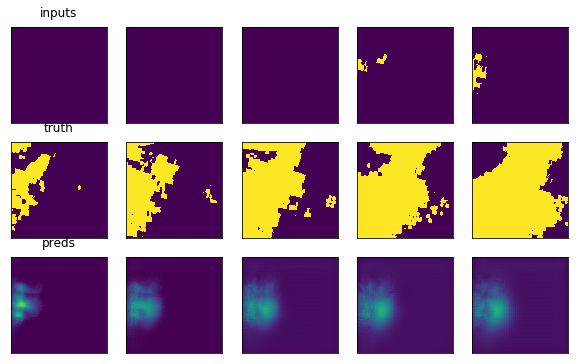

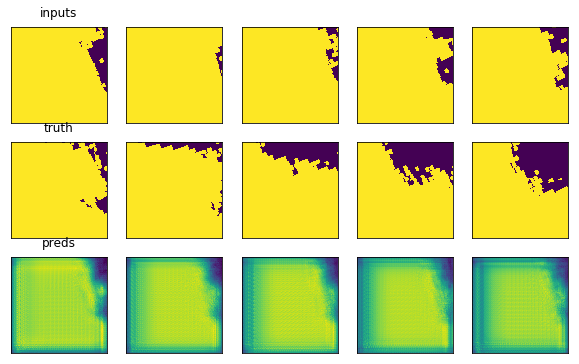

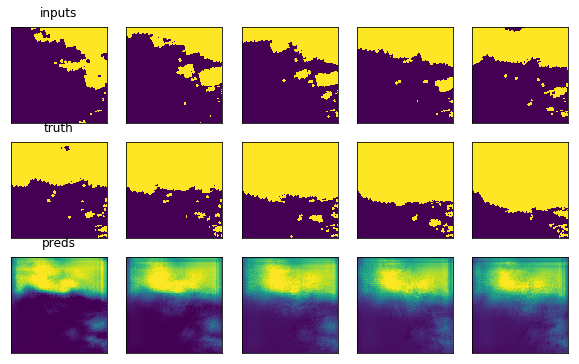

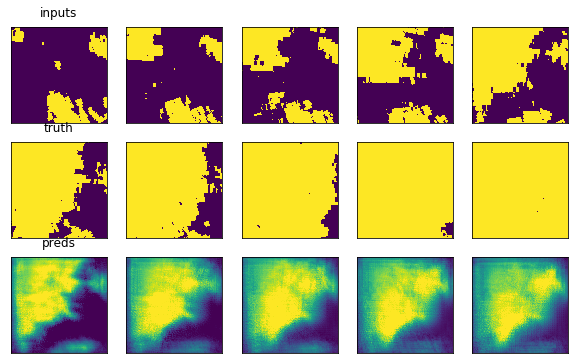

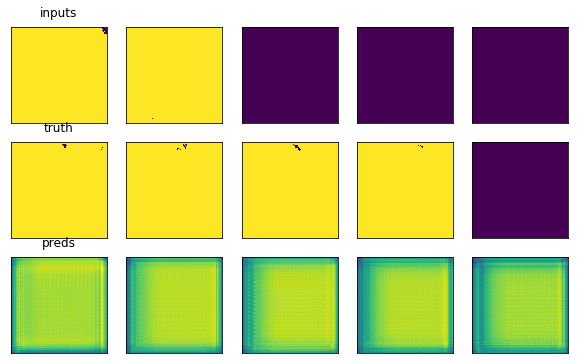

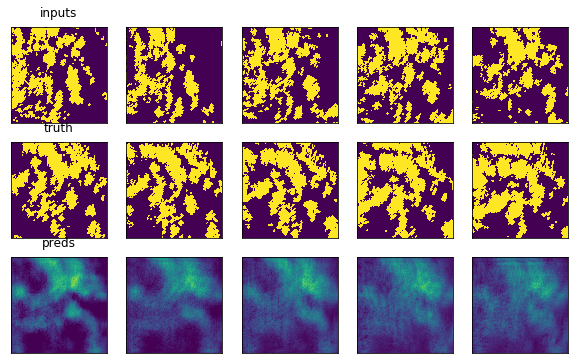

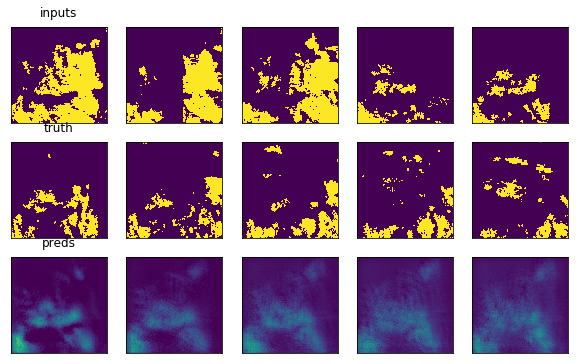

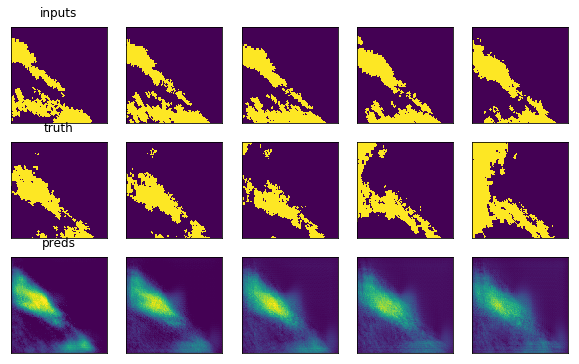

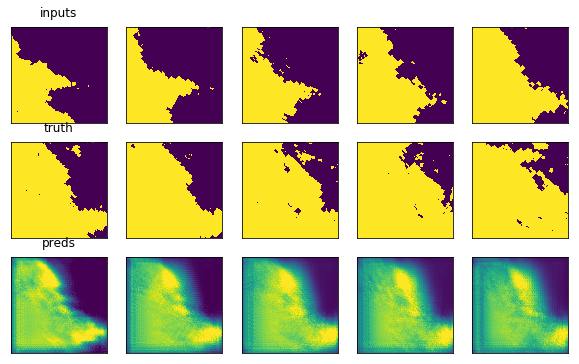

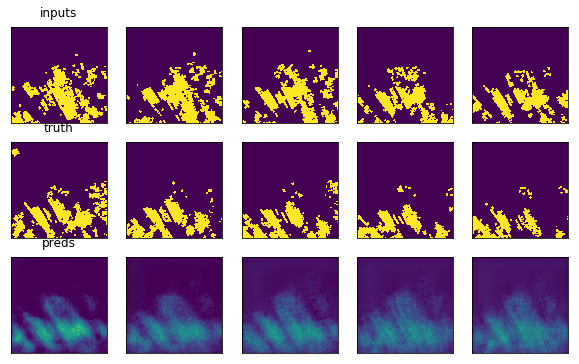

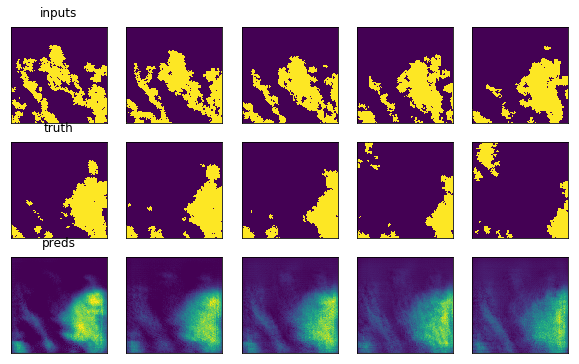

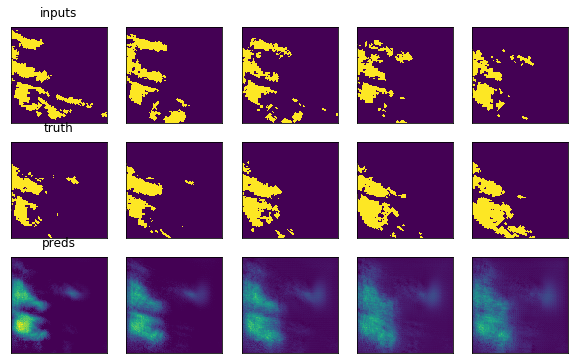

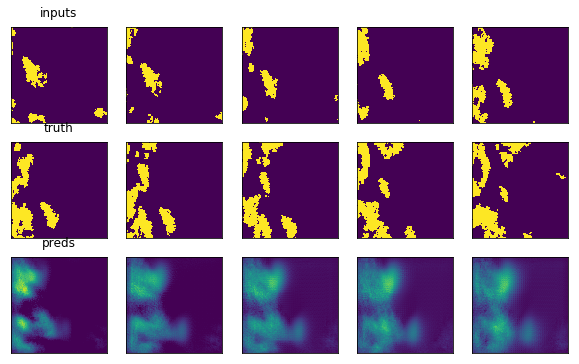

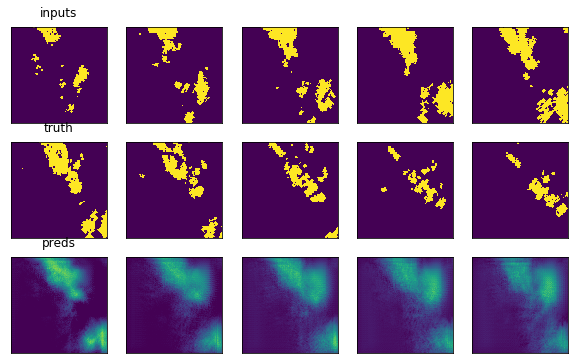

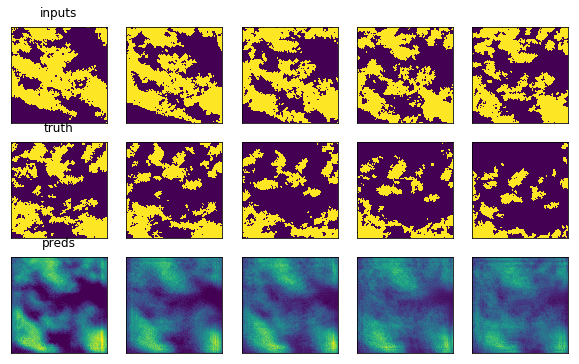

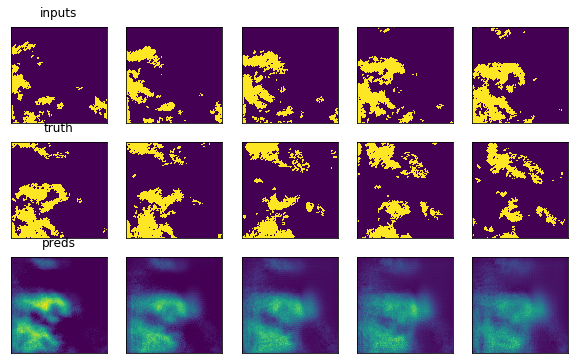

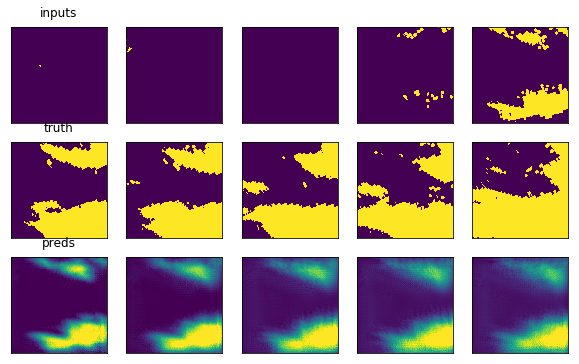

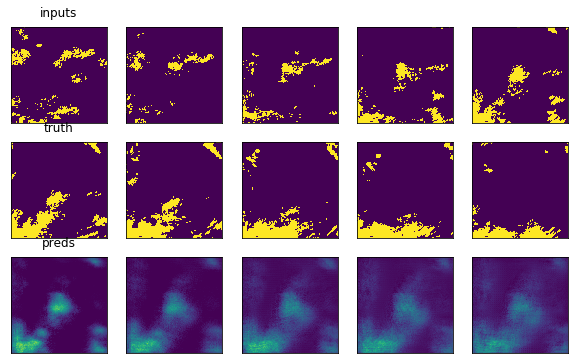

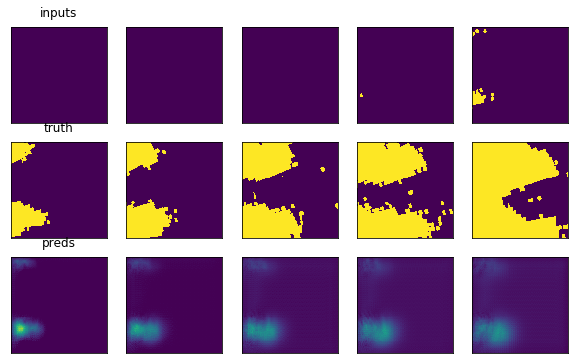

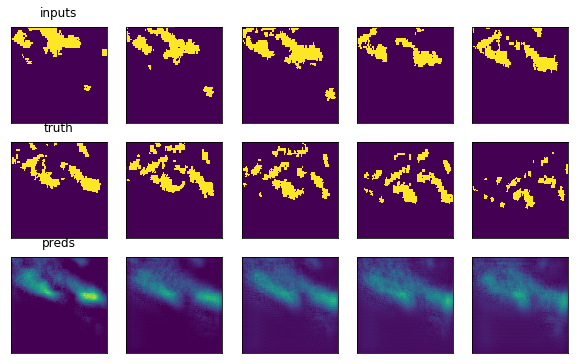

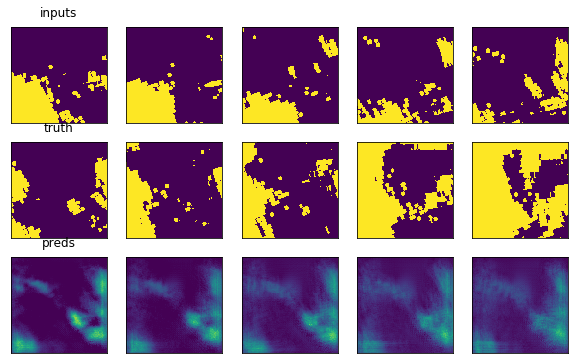

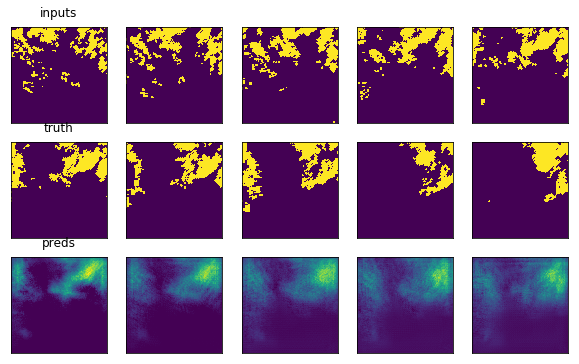

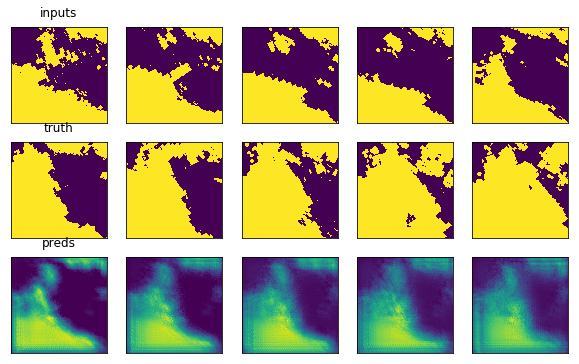

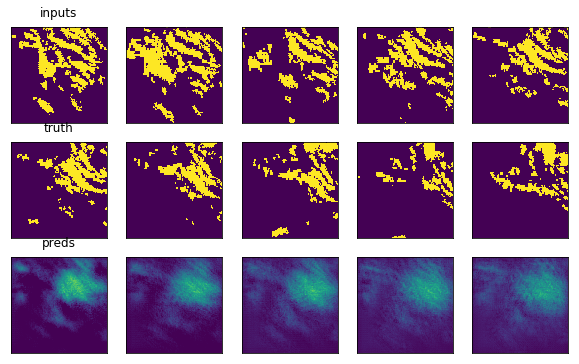

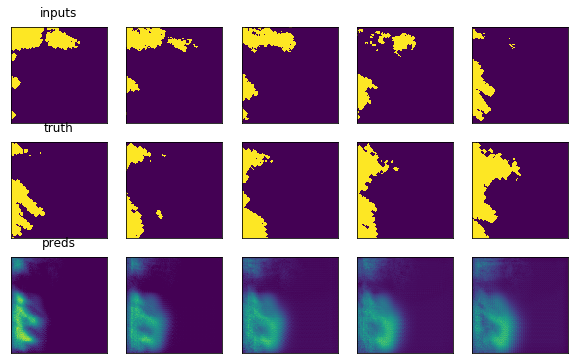

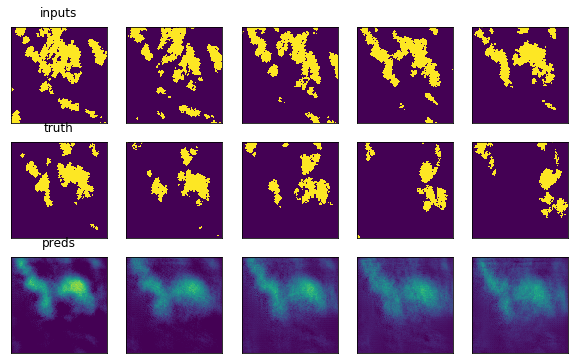

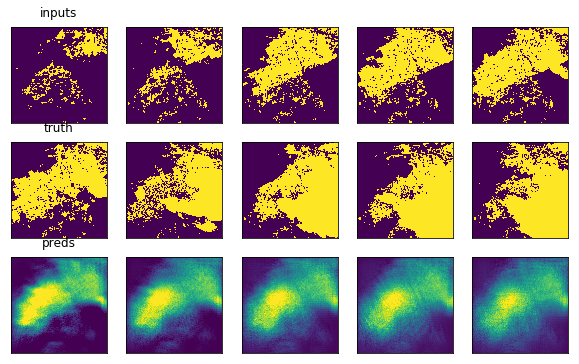

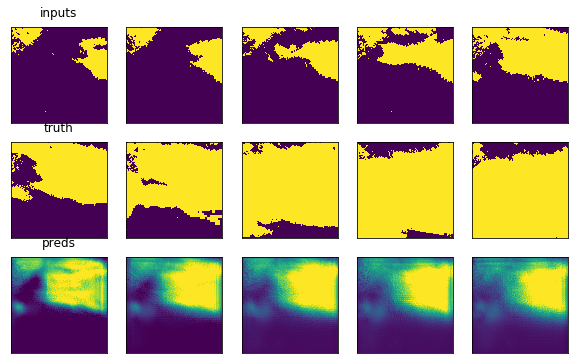

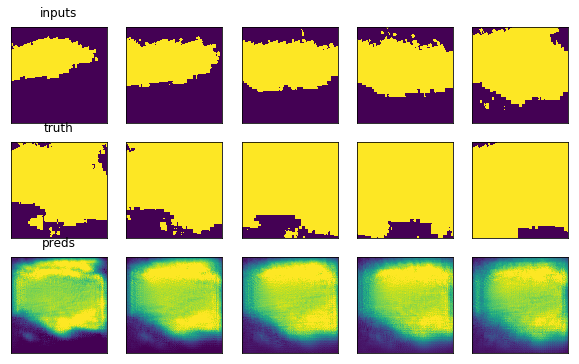

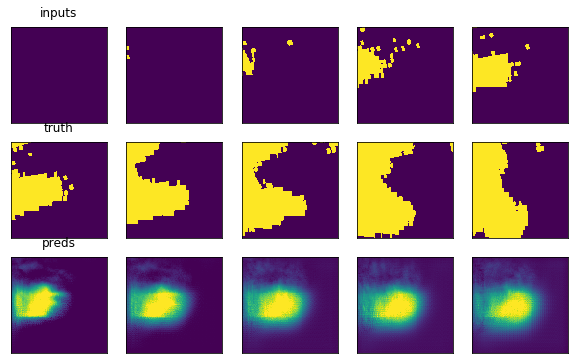

In [18]:
show_outputs(cnn_res_2, test_loader)